In [1]:
import random
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.utils.data
import cv2
import torch
import torchvision
import os
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
batchSize=1
imageSize=[128,128]

In [2]:
print(torchvision.__version__)
print(torch.__version__)

0.14.0
1.13.0


In [3]:
class config:
  CONFIG_SET = 0
  ROOT_DIR  = "./resize_128"
  IMAGE_DIR = "./resize_128/image"
  MASK_DIR = "./resize_128/mask"
  ANNOTATION_DIR =  "./resize_128/json"
  MODEL_DIR = "./resize_128/result/model/"
    
  WIDTH = 128
  HEIGHT = 128


  GPU = torch.device("cuda")
  CPU = torch.device("cpu")

  RESNET_MEAN = (0.485, 0.456, 0.406)
  RESNET_STD = (0.229, 0.224, 0.225)

  IMAGE_RESIZE=(128,128)

  BATCH_SIZE = 2

  MOMENTUM = 0.9
  LEARNING_RATE = 0.0001
  WEIGHT_DECAY = 0.0005


  MASK_THRESHOLD = 0.5

  NORMALIZE = False 


  USE_SCHEDULER = False

  NUM_EPOCHS = 4


  BOX_DETECTIONS_PER_IMG = 539

  NUM_CLASSES=2
  
  MIN_SCORE = 0.59

In [4]:
config_set = [
        {
            "ROOT_DIR"  : "./resize_128",
            "IMAGE_DIR" : "./resize_128/image",
            "MASK_DIR" : "./resize_128/mask",
            "ANNOTATION_DIR" :  "./resize_128/json",
            "MODEL_DIR" : "./resize_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./crop_128",
            "IMAGE_DIR" : "./crop_128/image",
            "MASK_DIR" : "./crop_128/mask",
            "ANNOTATION_DIR" :  "./crop_128/json",
            "MODEL_DIR" : "./crop_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./resize_512",
            "IMAGE_DIR" : "./resize_512/image",
            "MASK_DIR" : "./resize_512/mask",
            "ANNOTATION_DIR" :  "./resize_512/json",
            "MODEL_DIR" : "./resize_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        },
        {
            "ROOT_DIR"  : "./corp_512",
            "IMAGE_DIR" : "./corp_512/image",
            "MASK_DIR" : "./corp_512/mask",
            "ANNOTATION_DIR" :  "./corp_512/json",
            "MODEL_DIR" : "./corp_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        }
    ]

config.ROOT_DIR  = config_set[config.CONFIG_SET]["ROOT_DIR"]
config.IMAGE_DIR = config_set[config.CONFIG_SET]["IMAGE_DIR"]
config.MASK_DIR = config_set[config.CONFIG_SET]["MASK_DIR"]
config.ANNOTATION_DIR =config_set[config.CONFIG_SET]["ANNOTATION_DIR"]
config.MODEL_DIR = config_set[config.CONFIG_SET]["MODEL_DIR"]
config.WIDTH = config_set[config.CONFIG_SET]["WIDTH"]
config.HEIGHT = config_set[config.CONFIG_SET]["HEIGHT"]
config.IMAGE_RESIZE=config_set[config.CONFIG_SET]["IMAGE_RESIZE"]


In [5]:
data = []
for  image,annot,mask in zip(os.listdir(config.IMAGE_DIR), os.listdir(config.ANNOTATION_DIR), os.listdir(config.MASK_DIR)):
    with open(os.path.join(config.ANNOTATION_DIR,annot), "r") as file:
        dictionary = json.load(file)
        dictionary["file"] = os.path.join(config.IMAGE_DIR, image)
        dictionary["mask"] = os.path.join(config.MASK_DIR, mask)
        data.append(dictionary)

data = pd.DataFrame(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        7392 non-null   object
 1   n_object    7392 non-null   int64 
 2   annotation  7392 non-null   object
 3   box         7392 non-null   object
 4   mask        7392 non-null   object
dtypes: int64(1), object(4)
memory usage: 288.9+ KB


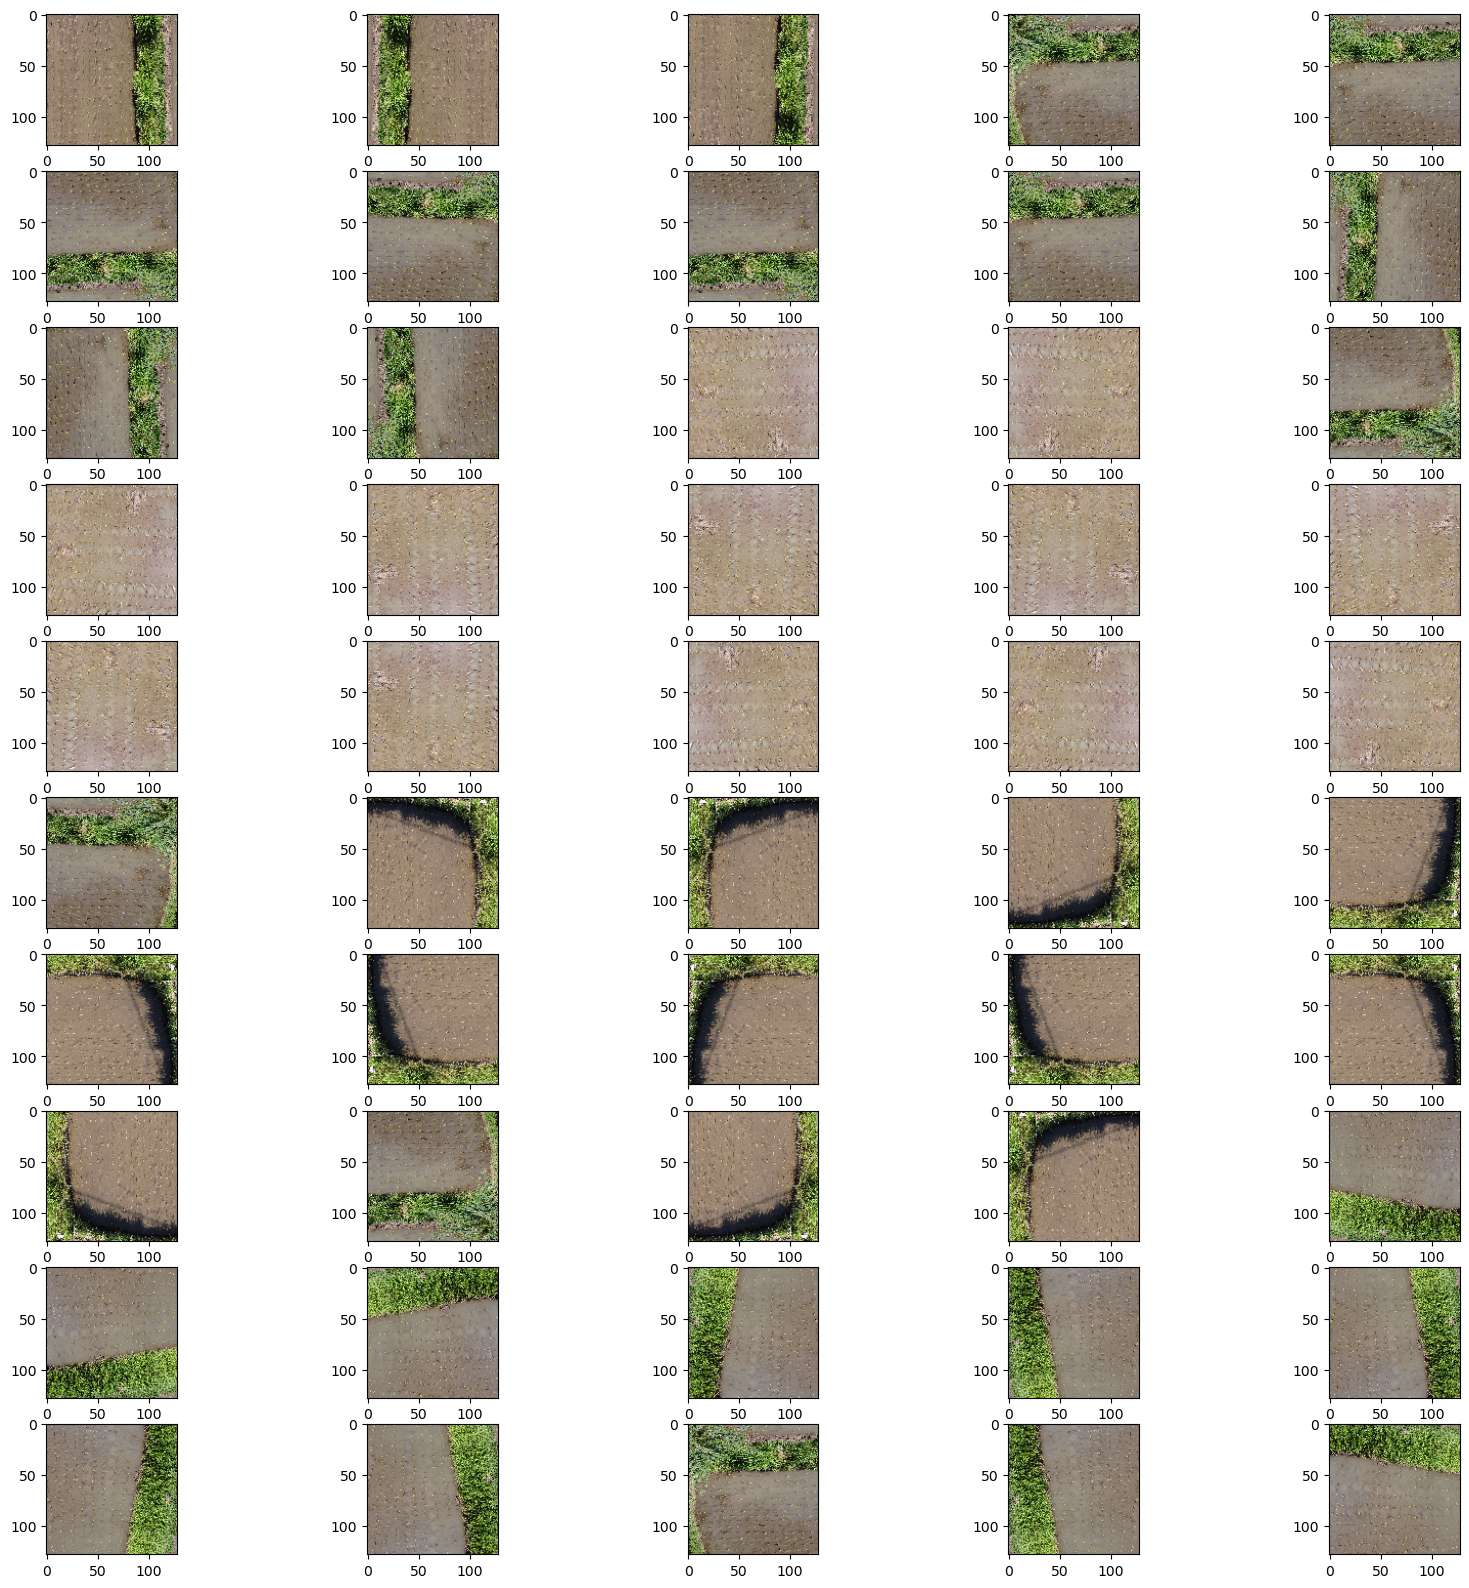

In [7]:
data_length = len(data)
w,h = 20,20

fig=plt.figure(figsize=(20, 20))
cols , rows = 5, 10

for i in range(cols*rows):
    if (i) == data_length:
        break
    image = plt.imread(data.loc[i,"file"])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image)

plt.show()

In [8]:
class Rice_Dataset(Dataset):
    def __init__(self, data):
        self.data = data 
        self.image_data=collections.defaultdict(dict)  
        self.height=config.HEIGHT
        self.width=config.WIDTH
        for index,row in data.iterrows():
            self.image_data[index]={
                'image_path': row["file"],
                'annotations':row["annotation"],
                'n_object':row["n_object"],
                'mask': row["mask"],
                'box':row["box"]
            }
    def __getitem__(self,id):
        image_current = self.image_data[id]
        image=Image.open(image_current["image_path"]).convert("RGB")
        image = F.to_tensor(image)
        masks = np.zeros((image_current["n_object"], self.height, self.width), dtype=np.uint8)
        boxes =image_current["box"]
        # print (boxes)
        # for i, annotation in enumerate(image_current["annotations"]):
        #     masks = process_annottation(annotation, (config.HEIGHT,config.WIDTH))
        #     # masks[i,:,:] = np.array(Image.fromarray(mask))>0
        maskImg = cv2.imread(image_current["mask"])
        # masks = [(maskImg > 0).astype(np.uint8)]
        maskImg = cv2.bitwise_not(maskImg)
        gray = cv2.cvtColor(maskImg,cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        # print("n_object", image_current["n_object"])
        # print("contour", len(contours))
        for i,contour in enumerate(contours) :
            mask_bin = np.zeros((self.height, self.width),dtype=np.uint8)
            contour = np.array([i[0] for i in contour])
            cv2.drawContours(mask_bin, [contour], -1, (255,255,255), 1)
            cv2.fillPoly(mask_bin, [contour], (255,255,255))
            
            masks[i,:,:] = np.array(Image.fromarray(mask_bin))>0
            

        labels=[1 for _ in range(image_current["n_object"])]
        
        boxes=torch.as_tensor(boxes,dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id=torch.tensor([id])
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((image_current["n_object"],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return image, target
    def __len__(self):
        return len(self.image_data)
    
        


In [9]:
def collate_fn(data):
    return tuple(zip(*data))
    
dataset_rice = Rice_Dataset(data)
load=DataLoader(dataset_rice,batch_size=config.BATCH_SIZE,shuffle=True, collate_fn=collate_fn)

In [10]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,box_detections_per_img=config.BOX_DETECTIONS_PER_IMG)
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,config.NUM_CLASSES)
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer=256
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask,hidden_layer,config.NUM_CLASSES)
model.to(config.GPU)
for param in model.parameters():
    param.requires_grad=True
model.train()

d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [11]:
import pandas as pd
class train_log():
    def __init__(self, n_batch, n_epoch):
        self.logs = []
        self.n_batch = n_batch
        self.n_epoch = n_epoch
        self.loss_accum=0.0
        self.loss_mask_accum=0.0
    
    def log(self, epoch, batch, loss_dict, display=False):
        loss = sum(loss for loss in loss_dict.values())
        loss_mask=loss_dict['loss_mask'].item()
        self.loss_accum+=loss.item()
        self.loss_mask_accum+=loss_mask
        log = {
            "epoch" :epoch,
            "batch" : batch,
            "mask_loss": loss_mask,
            "loss": loss.item(),
            "train_loss" : self.loss_accum / self.n_batch,
            "train_loss_mask" : self.loss_mask_accum / self.n_batch
        }
        self.logs.append(log)
        if  display:
            print(log)
    
    def export_csv(self, path):
        df = pd.DataFrame(self.logs)
        df.to_csv(path, index=False)
        
    def to_df(self):
        return pd.DataFrame(self.logs)
    
    def __len__(self):
        return len(self.logs)

        

In [12]:
import os
import shutil
if os.path.exists(config.MODEL_DIR):
    shutil.rmtree(config.MODEL_DIR)
os.makedirs(config.MODEL_DIR)

params=[p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.SGD(params,lr=config.LEARNING_RATE,momentum=config.MOMENTUM,weight_decay=config.WEIGHT_DECAY)

lr_schedule=torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
n_batches=len(load)
logs = train_log(n_batches, config.NUM_EPOCHS)
# debug_image,_ =  dataset_rice[0]
for epoch in range(config.NUM_EPOCHS):
    loss_accum=0.0
    loss_mask_accum=0.0
    
    for batch,(images,targets) in enumerate(load,1):
        
        images = list(image.to(config.GPU) for image in images)
        targets = [{key: value.to(config.GPU) for key, value in target.items()} for target in targets]
        
        loss_dict=model(images,targets)
        loss = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        logs.log(epoch, batch, loss_dict, display=True)
    torch.save(model.state_dict(), config.MODEL_DIR+str(epoch)+".torch")
    

{'epoch': 0, 'batch': 1, 'mask_loss': 6.917642116546631, 'loss': 8.501779556274414, 'train_loss': 0.002300265031459528, 'train_loss_mask': 0.0018716564168145646}
{'epoch': 0, 'batch': 2, 'mask_loss': 7.40783166885376, 'loss': 8.843116760253906, 'train_loss': 0.004692883202523896, 'train_loss_mask': 0.0038759398770022704}
{'epoch': 0, 'batch': 3, 'mask_loss': 2.4497294425964355, 'loss': 3.7433032989501953, 'train_loss': 0.00570568171414462, 'train_loss_mask': 0.0045387454621203535}
{'epoch': 0, 'batch': 4, 'mask_loss': 0.22951386868953705, 'loss': 1.2187774181365967, 'train_loss': 0.006035437509094998, 'train_loss_mask': 0.0046008433703155745}
{'epoch': 0, 'batch': 5, 'mask_loss': 0.47282177209854126, 'loss': 1.341273307800293, 'train_loss': 0.006398336131335337, 'train_loss_mask': 0.004728771338956955}
{'epoch': 0, 'batch': 6, 'mask_loss': 0.10238449275493622, 'loss': 0.8634053468704224, 'train_loss': 0.006631941474103308, 'train_loss_mask': 0.004756472770979394}
{'epoch': 0, 'batch': 

In [16]:
def demo(model, ds_train, num):
    data_length = len(dataset_rice)
    
    w,h = 20,20
    fig=plt.figure(figsize=(9, num*3))
    cols , rows = 3, num
    cell = 0
    for i in range(num):
        img, targets = ds_train[random.randint(0,data_length-1)]
        image = plt.imread(data.loc[i,"file"])
        cell +=1
        fig.add_subplot(rows, cols, cell)
        plt.imshow(img.numpy().transpose((1,2,0)))

    
        masks = np.zeros((config.HEIGHT, config.WIDTH))
        for mask in targets['masks']:
            masks = np.logical_or(masks, mask)
        cell +=1
        fig.add_subplot(rows, cols, cell)
        # plt.imshow(img.numpy().transpose((1,2,0)))
        plt.imshow(masks, alpha=0.3)
    
        model.eval()
        with torch.no_grad():
            preds = model([img.to(config.GPU)])[0]
        cell +=1
        fig.add_subplot(rows, cols, cell)
        # plt.imshow(img.cpu().numpy().transpose((1,2,0)))
        all_preds_masks = np.zeros((config.HEIGHT, config.WIDTH))
        for mask in preds['masks'].cpu().detach().numpy():
            all_preds_masks = np.logical_or(all_preds_masks, mask[0] > config.MASK_THRESHOLD)
        plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

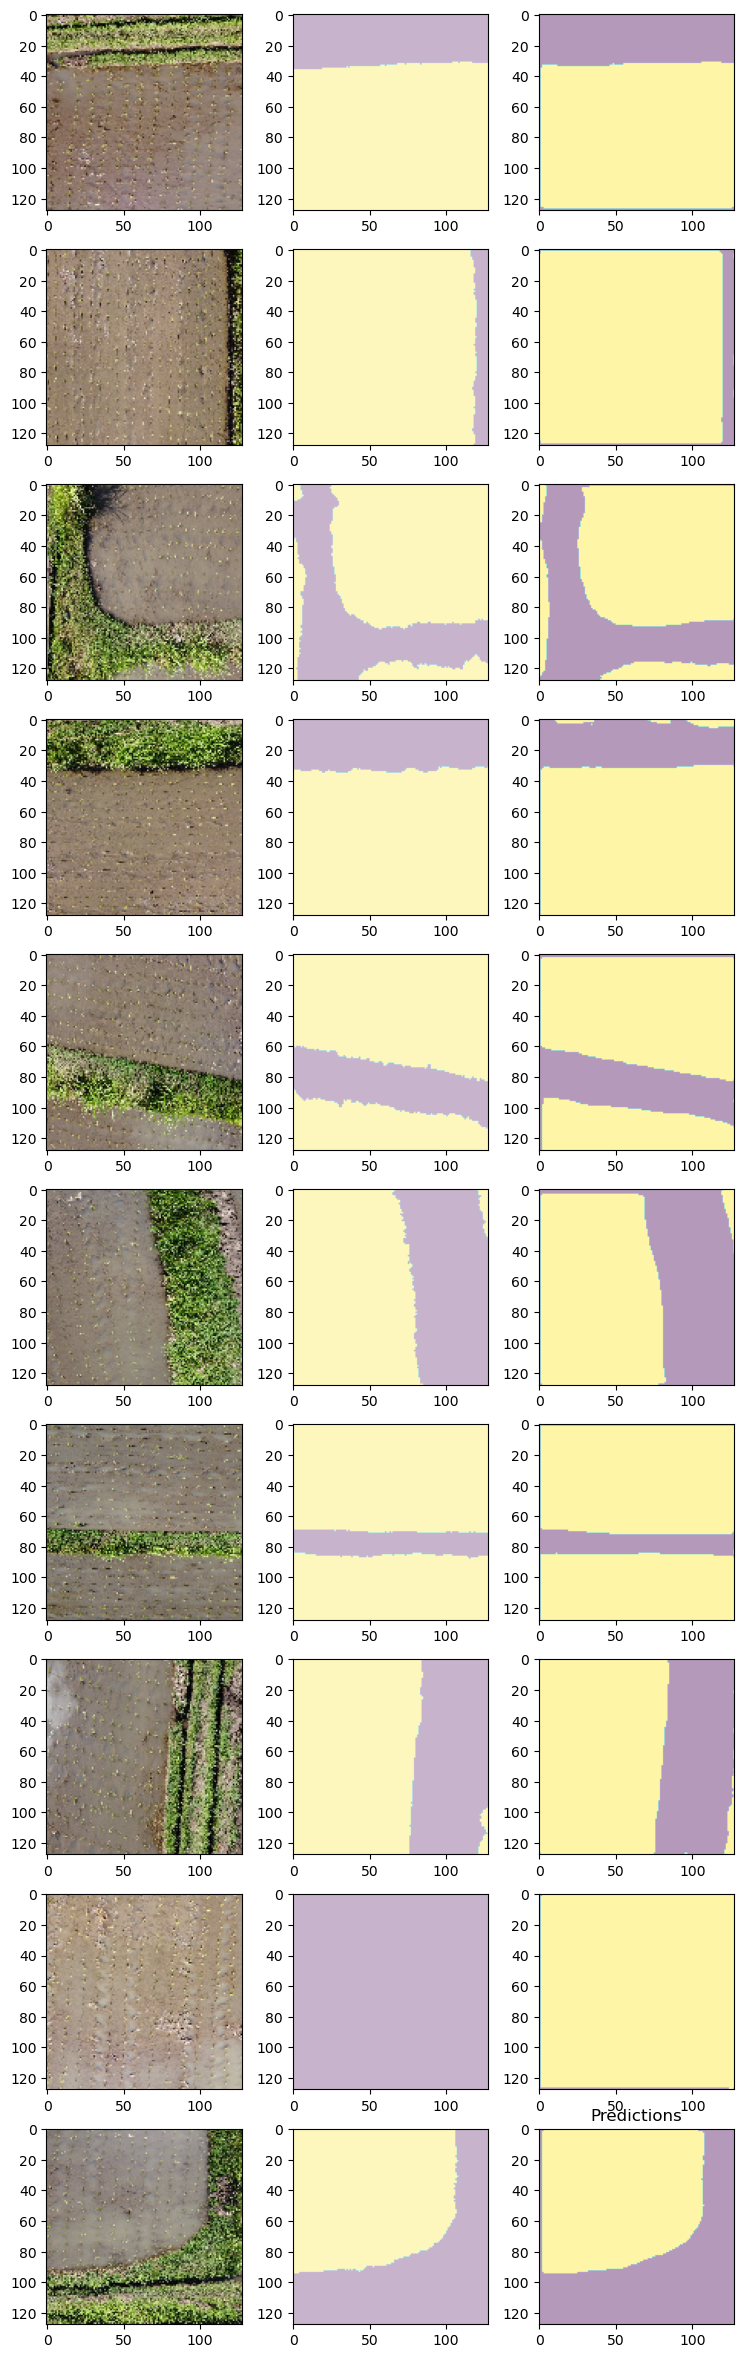

In [21]:
demo(model, dataset_rice,10)

In [19]:
logs.export_csv(config.MODEL_DIR+"log.csv")